### Cab-Driver Agent

#### <u>NOTES</u>:

#### 1. As per problem statement - This is actually Architecture 2 implementation.

In <b>Env.py</b> provided, <b>state_encod_arch1</b> function referred to encoding states which is applicable to Architecture 2 as per problem statement. Since it was referred as Architecture 1 in Env.py so using DQN_Agent_Architecture1 notebook but just note that this is Architecture 2 implementation as such as far as problem statement is concerned.

#### 2. Providing model and weights inform of .h5 (HDF) and .pkl (Pickle) both. Model is also provided inform of JSON.

<b>3.</b><br></br> 
<b>(a) In save_model folder - Saved model and weights, are present.</b><br></br>
<b>(b) In save_graph folder - Saved plots (rewards, steps and epsilon) per episode, are present.</b><br></br>
<b>(c) In save_tracking folder - Saved tracked states and rewards, are present.</b>

#### 4. Epsilon decay function used, is shown at the bottom of this notebook.

#### 5. Simulation was run for 15000 episodes which took around ~ 7 - 8 hrs.

In [1]:
# Import warnings and ignore
import warnings
warnings.filterwarnings("ignore")

# Importing libraries
import numpy as np
import random
import math
from collections import deque, defaultdict
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# Import tensorflow and set logging to error
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# for plotting graphs
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

# General purpose
import os
import time

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Function for initializing tracking states

def initialize_tracking_states():
    
    state_action_pairs = [((1, 1, 1), (1, 2)),
                          ((1, 2, 3), (1, 3)),
                          ((2, 2, 2), (2, 3)),
                          ((2, 3, 4), (2, 4)),
                          ((3, 3, 3), (3, 4)),
                          ((3, 4, 5), (3, 2)),
                          ((4, 4, 4), (4, 3)), 
                          ((4, 5, 6), (4, 2))]

    for state, action in state_action_pairs:
        if state not in States_track:
            States_track[state] = defaultdict()
        States_track[state][action] = list()

In [4]:
# Function for saving tracking states

def save_tracking_states():
    
    for state in States_track.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, state_size)
        q_predict = dqn_agent.model.predict(encoded_state)

        for action in States_track[state].keys():
            action_index = env.action_space.index(action)
            q_value = q_predict[0][action_index]
            States_track[state][action].append(q_value)

In [5]:
# Initialize tracking states

States_track = defaultdict()
initialize_tracking_states()
States_track

defaultdict(None,
            {(1, 1, 1): defaultdict(None, {(1, 2): []}),
             (1, 2, 3): defaultdict(None, {(1, 3): []}),
             (2, 2, 2): defaultdict(None, {(2, 3): []}),
             (2, 3, 4): defaultdict(None, {(2, 4): []}),
             (3, 3, 3): defaultdict(None, {(3, 4): []}),
             (3, 4, 5): defaultdict(None, {(3, 2): []}),
             (4, 4, 4): defaultdict(None, {(4, 3): []}),
             (4, 5, 6): defaultdict(None, {(4, 2): []})})

In [6]:
# Defining a function to save passed object as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
# DQN Agent Class
###########################################################################################################################
class DQNAgent:
    #######################################################################################################################
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.90
        self.learning_rate = 0.01 
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.001
        self.epsilon = 1.0
        
        # Define batch size
        self.batch_size = 32     
        
        # Create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Create model
        self.model = self.build_model()

    #######################################################################################################################
    # Build Model - Approximate Q function using Neural Network
    def build_model(self):
        
        model = Sequential()
        # Write your code here: Add layers to your neural nets       

        # Input layer - state_size
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))

        # Hidden layer
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # Output layer - action_size
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
     
        # Compile model
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate), metrics=['mse', 'msle'])
        
        # Model summary
        model.summary
        
        return model

    #######################################################################################################################
    def get_action(self, state, episode, possible_actions_index, possible_actions):
    # Write your code here:
    # Get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       

       
        # Calculate epsilon for a given episode
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)

        z = np.random.random()
        
        if z > self.epsilon:
            # Exploitation - Choose action with max Q(s, a)
            
            # First index corresponds to size so reshape to (1, state_size)
            encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            
            # Predict q-values of all possible actions for a given state
            predicted_q_values = self.model.predict(encoded_state)
            
            # Find q-values corresponding to possible actions index
            possible_q_values = [predicted_q_values[0][i] for i in possible_actions_index]
            
            # Select action index corresponding to max Q-value
            max_q_value_index = np.argmax(possible_q_values)

            # Select action (request) with maximum q-value
            action = possible_actions[max_q_value_index]

        else:
            # Exploration

            # Select a random action (request) from possible requests space
            action = random.choice(possible_actions)
            
        return action
        
    #######################################################################################################################
    def append_sample(self, state, action, reward, next_state, terminal_state):
    # Write your code here:
    # save sample <s,a,r,s',ts> to the replay memory - ts - terminal state
    
        self.memory.append((state, action, reward, next_state, terminal_state))
    
    #######################################################################################################################
    # Train model - Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                
                state, action, reward, next_state, terminal_state = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target_q_values = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            next_state_q_values = self.model.predict(update_output)
                
            #3. Update your target q values
            
            # For each element in the batch, update respective q-values using predicted and target q-values
            for i in range(self.batch_size):
                # Each memory element is of form (s, a, r, s', ts)
                # Output of NN for a given state generates q-values for all possible actions
                # But q-value update must be made to only that action 'a', out of all possible actions in the output

                action_index = env.action_space.index(actions[i])

                # If it is terminal state - episode ending after 30 days
                if terminal_states[i]:
                    
                    target_q_values[i][action_index] = rewards[i]
                # If it is a non terminal state
                else:
                    # Update q-value using formula (r + γ * max Q(s',a))
                    target_q_values[i][action_index] = rewards[i] + (self.discount_factor * np.max(next_state_q_values[i]))             
                
            # 4. Fit your model and track the loss values
            # Train the model with updated Q-values
            model_history = self.model.fit(update_input, target_q_values, batch_size=self.batch_size, epochs=1, verbose=0)
            
            return model_history

    #######################################################################################################################
    # Save model and architecture in same file
    def save(self, name):
        self.model.save(name)
    
    #######################################################################################################################
    # Save model weights
    def save_model_weights(self, name):
        self.model.save_weights(name)

    #######################################################################################################################
    # Save model inform of JSON
    def save_model_json(self, name):
        # Serialize model to JSON
        model_json = self.model.to_json()
        with open(name, "w") as json_file:
            json_file.write(model_json)
###########################################################################################################################

#### Setup episodes, hyperparameters, some arrays, some directories and DQN Agent

In [8]:
Episodes = 15000 # No of episodes

STATES_TRACKING = 15 # Save states being tracked after every 15 episodes
EPISODE_TRACKING = 150 # Save model and print various metrices after every 150 episodes

episode_max_time = 24*30 # 30 days after which car will have to be recharged

# Defining hyperparameters
m = 5
t = 24
d = 7

# Set up state and action sizes.
state_size = m + t + d
action_size = ((m - 1) * m) + 1

# Setup some arrays to hold values during episodes
episodes, rewards, steps, epsilons, mse, msle = [], [], [], [], [], []

# Setup some directories to save model, graphs and tracked states / rewards
if not os.path.exists('save_model'):
    os.makedirs('save_model')

if not os.path.exists('save_graph'):
    os.makedirs('save_graph')

if not os.path.exists('save_tracking'):
    os.makedirs('save_tracking')
    
# Invoke agent class
dqn_agent = DQNAgent(state_size=state_size, action_size=action_size)
dqn_agent.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


### DQN block

In [9]:
start_time = time.time()

# Create environment object so agent can interact
env = CabDriver()

####################################### Start episodes - loop starts ######################################################
for episode in range(Episodes):

    # Write code here
    # Call the environment

    action_space, state_space, state_init = env.reset()
    
    current_state = state_init
    
    # Reset tracking variables
    terminal_state = False
    time_per_episode = 0
    reward_per_episode = 0
    step_per_episode = 0

    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss        
        
        # Fetch possible actions index and respective actions for a given state - requests space
        # Number of requests per location are calculated based on a poisson distribution as per MDP
        possible_actions_index, possible_actions = env.requests(current_state)

        # Get current action based on epsilon-greedy strategy
        current_action = dqn_agent.get_action(current_state, episode, possible_actions_index, possible_actions)

        # Given current state and action, calculate next state, reward and ride time - take a step
        next_state, reward, total_time = env.step(current_state, current_action, Time_matrix)

        time_per_episode += total_time
        reward_per_episode += reward

        if time_per_episode >= episode_max_time:
            terminal_state = True

        # Append current experience to replay memory buffer
        dqn_agent.append_sample(current_state, current_action, reward, next_state, terminal_state)

        # Train the model
        dqn_model_history = dqn_agent.train_model()
        
        if dqn_model_history is not None:
            mse.append(dqn_model_history.history['mean_squared_error'])
            msle.append(dqn_model_history.history['mean_squared_logarithmic_error'])
        
        current_state = next_state
        step_per_episode += 1

    rewards.append(reward_per_episode)
    steps.append(step_per_episode)
    episodes.append(episode)
    epsilons.append(dqn_agent.epsilon)
    
    # Save states being tracked
    if ((episode+1)%STATES_TRACKING)==0:
        save_tracking_states()

    # Track episodes - Save model, check progress and display metrics being tracked
    if ((episode+1)%EPISODE_TRACKING)==0:
        
        # Save model and weights in .h5 (HDF) files
        dqn_agent.save("./save_model/DQN_Model.h5")
        dqn_agent.save_model_weights("./save_model/DQN_Model_Weights.h5")
        
        # Save model and weights in .pkl (Pickle) files
        save_obj(dqn_agent.model,'./save_model/dql_model')
        save_obj(dqn_agent.model.get_weights(),'./save_model/dqn_model_weight')
        
        # Save model json as well
        dqn_agent.save_model_json("./save_model/DQN_Model_JSON.json")
        
        
        print("Episode : %5d -- Reward                 : %10.2f -- Epsilon                            : %10.5f"
                                                            % (episode + 1, reward_per_episode, dqn_agent.epsilon))
        print("Episode : %5d -- Avg Monthly Reward     : %10.2f -- Avg Number of Steps                : %10.5f"
                                                            % (episode + 1, np.mean(rewards), np.mean(steps)))        
        print("Episode : %5d -- Avg Mean Squared Error : %10.2f -- Avg Mean Squared Logarithmic Error : %10.5f" 
                                                            % (episode + 1, np.mean(mse), np.mean(msle)))
        print("\n")
####################################### Start episodes - loop ends ########################################################

# Save objects being tracked in pickle files
save_obj(States_track,'./save_tracking/States_Tracked')
save_obj(rewards,'./save_tracking/Rewards_Per_Episode_Tracked')

elapsed_time = time.time() - start_time
print("\nElapsed time :", elapsed_time)

Episode :   150 -- Reward                 :    -126.00 -- Epsilon                            :    0.92828
Episode :   150 -- Avg Monthly Reward     :    -149.24 -- Avg Number of Steps                :  139.28667
Episode :   150 -- Avg Mean Squared Error :     998.75 -- Avg Mean Squared Logarithmic Error :    0.21558


Episode :   300 -- Reward                 :     133.00 -- Epsilon                            :    0.86128
Episode :   300 -- Avg Monthly Reward     :     -89.32 -- Avg Number of Steps                :  137.93000
Episode :   300 -- Avg Mean Squared Error :     586.32 -- Avg Mean Squared Logarithmic Error :    0.13862


Episode :   450 -- Reward                 :     220.00 -- Epsilon                            :    0.79912
Episode :   450 -- Avg Monthly Reward     :     -33.67 -- Avg Number of Steps                :  137.81111
Episode :   450 -- Avg Mean Squared Error :     431.02 -- Avg Mean Squared Logarithmic Error :    0.10970


Episode :   600 -- Reward               

Episode :  3900 -- Avg Mean Squared Error :      77.80 -- Avg Mean Squared Logarithmic Error :    0.02156


Episode :  4050 -- Reward                 :    1453.00 -- Epsilon                            :    0.13293
Episode :  4050 -- Avg Monthly Reward     :     713.34 -- Avg Number of Steps                :  132.01728
Episode :  4050 -- Avg Mean Squared Error :      75.73 -- Avg Mean Squared Logarithmic Error :    0.02092


Episode :  4200 -- Reward                 :    1233.00 -- Epsilon                            :    0.12340
Episode :  4200 -- Avg Monthly Reward     :     731.81 -- Avg Number of Steps                :  131.87333
Episode :  4200 -- Avg Mean Squared Error :      73.83 -- Avg Mean Squared Logarithmic Error :    0.02034


Episode :  4350 -- Reward                 :    1485.00 -- Epsilon                            :    0.11455
Episode :  4350 -- Avg Monthly Reward     :     749.36 -- Avg Number of Steps                :  131.82276
Episode :  4350 -- Avg Mean Squared Erro

Episode :  7800 -- Avg Mean Squared Error :      49.44 -- Avg Mean Squared Logarithmic Error :    0.01276


Episode :  7950 -- Reward                 :    1518.00 -- Epsilon                            :    0.01977
Episode :  7950 -- Avg Monthly Reward     :    1041.72 -- Avg Number of Steps                :  131.52075
Episode :  7950 -- Avg Mean Squared Error :      48.91 -- Avg Mean Squared Logarithmic Error :    0.01258


Episode :  8100 -- Reward                 :    1152.00 -- Epsilon                            :    0.01841
Episode :  8100 -- Avg Monthly Reward     :    1050.35 -- Avg Number of Steps                :  131.54025
Episode :  8100 -- Avg Mean Squared Error :      48.38 -- Avg Mean Squared Logarithmic Error :    0.01241


Episode :  8250 -- Reward                 :    1386.00 -- Epsilon                            :    0.01716
Episode :  8250 -- Avg Monthly Reward     :    1058.16 -- Avg Number of Steps                :  131.55915
Episode :  8250 -- Avg Mean Squared Erro

Episode : 11700 -- Avg Mean Squared Error :      39.63 -- Avg Mean Squared Logarithmic Error :    0.00967


Episode : 11850 -- Reward                 :    1627.00 -- Epsilon                            :    0.00367
Episode : 11850 -- Avg Monthly Reward     :    1204.05 -- Avg Number of Steps                :  132.34852
Episode : 11850 -- Avg Mean Squared Error :      39.36 -- Avg Mean Squared Logarithmic Error :    0.00960


Episode : 12000 -- Reward                 :    1872.00 -- Epsilon                            :    0.00348
Episode : 12000 -- Avg Monthly Reward     :    1209.34 -- Avg Number of Steps                :  132.44633
Episode : 12000 -- Avg Mean Squared Error :      39.10 -- Avg Mean Squared Logarithmic Error :    0.00952


Episode : 12150 -- Reward                 :    1458.00 -- Epsilon                            :    0.00330
Episode : 12150 -- Avg Monthly Reward     :    1214.52 -- Avg Number of Steps                :  132.54708
Episode : 12150 -- Avg Mean Squared Erro

#### Plots to show rewards distribution over episodes, steps distribution over episodes and loss distribution

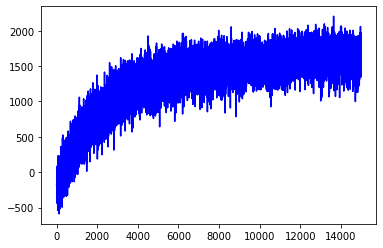

In [10]:
# Plot rewards distribution

pylab.plot(episodes, rewards, 'b')
pylab.savefig("./save_graph/dqn_reward_plot.png")

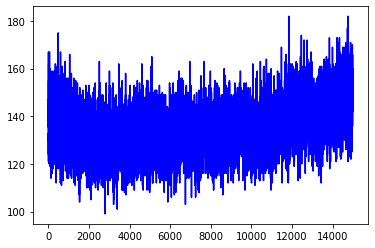

In [11]:
# Plot steps distribution

pylab.plot(episodes, steps, 'b')
pylab.savefig("./save_graph/dqn_steps_plot.png")

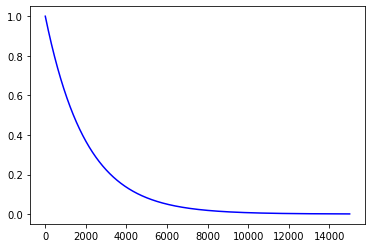

In [12]:
# Plot epsilons distribution

pylab.plot(episodes, epsilons, 'b')
pylab.savefig("./save_graph/dqn_epsilons_plot.png")

In [13]:
# Function to plot mse (Mean squared Error) and msle (Mean squared Logarithmic Error) from model history

def plot_model_history(mse, msle):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].plot(mse)   
    axes[0].set_title('MSE')
    
    axes[1].plot(msle) 
    axes[1].set_title('MSLE')

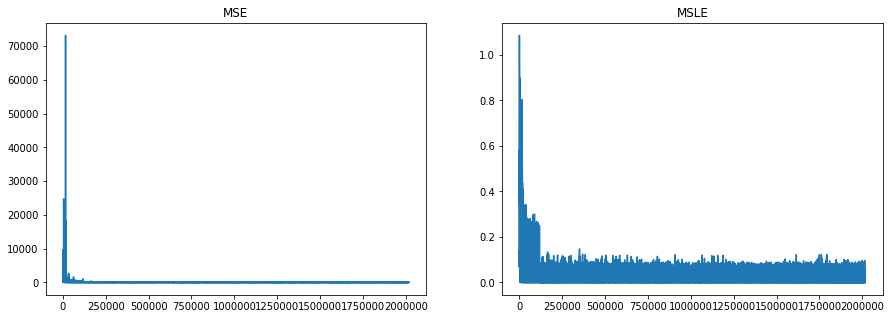

In [14]:
# Plot mse (Mean squared Error) and msle (Mean squared Logarithmic Error)

plot_model_history(mse, msle)

### Tracking Convergence

In [15]:
# Get no of iterations for state-action pair tracked

state_values = defaultdict(dict)

for state in States_track.keys():
    for action in States_track[state].keys():
        total_tracked_values = len(States_track[state][action])
        state_values[state][action] = total_tracked_values

state_values

defaultdict(dict,
            {(1, 1, 1): {(1, 2): 1000},
             (1, 2, 3): {(1, 3): 1000},
             (2, 2, 2): {(2, 3): 1000},
             (2, 3, 4): {(2, 4): 1000},
             (3, 3, 3): {(3, 4): 1000},
             (3, 4, 5): {(3, 2): 1000},
             (4, 4, 4): {(4, 3): 1000},
             (4, 5, 6): {(4, 2): 1000}})

In [16]:
# Function to show convergence plot

def plot_q_val_convergence(state, action):

    tracked_q_values = States_track[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

<Figure size 1440x1080 with 0 Axes>

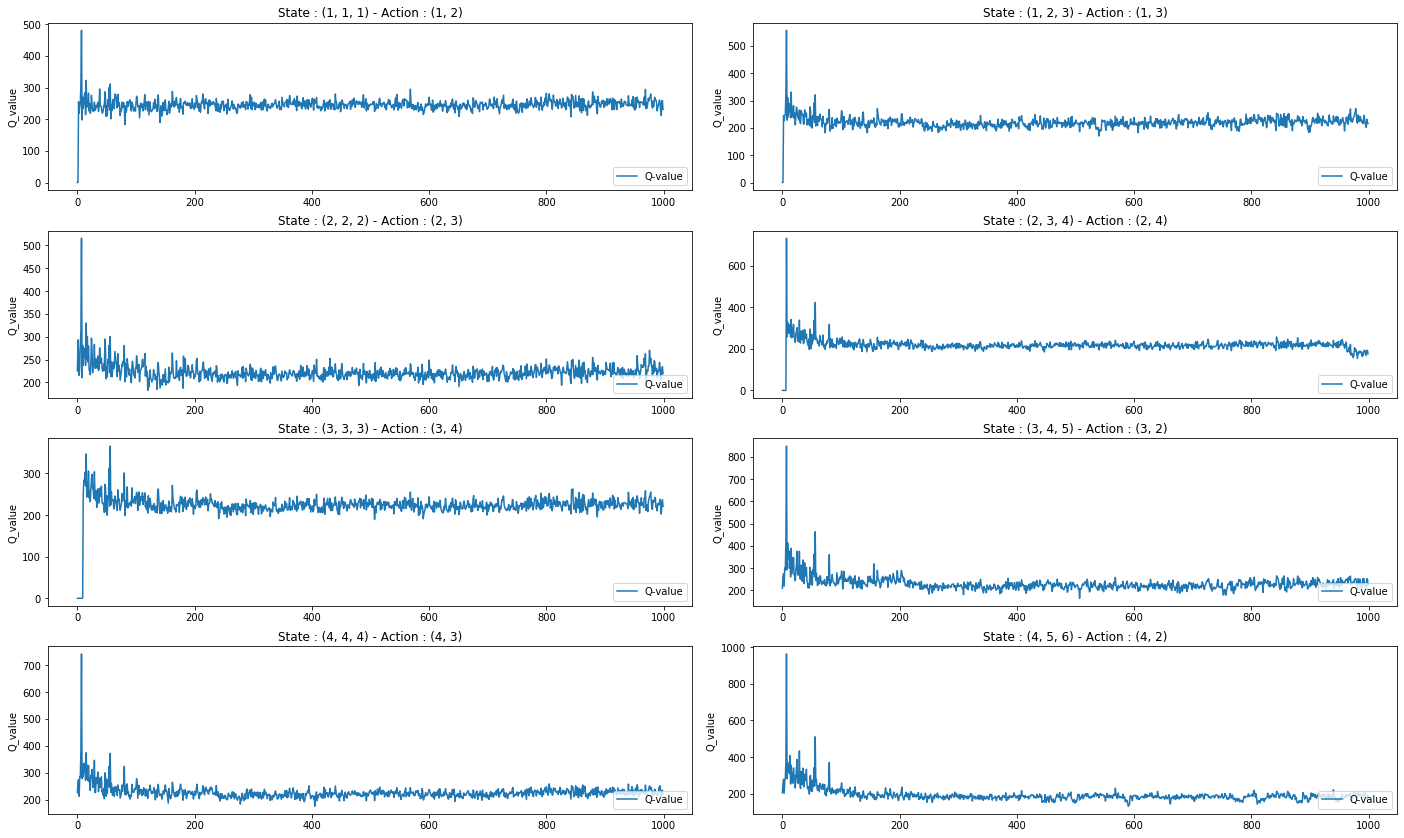

In [17]:
# Write the code to plot graphs for state-action pairs tracked to show convergence

plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
fig.tight_layout(pad=3.0)

subplots = [i for i in range(521, 529)]

i = 0

for state in state_values.keys():
    for action in state_values[state].keys():
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i+=1

plt.show()

#### All 8 state-action pairs tracked showing convergence as shown in above plots

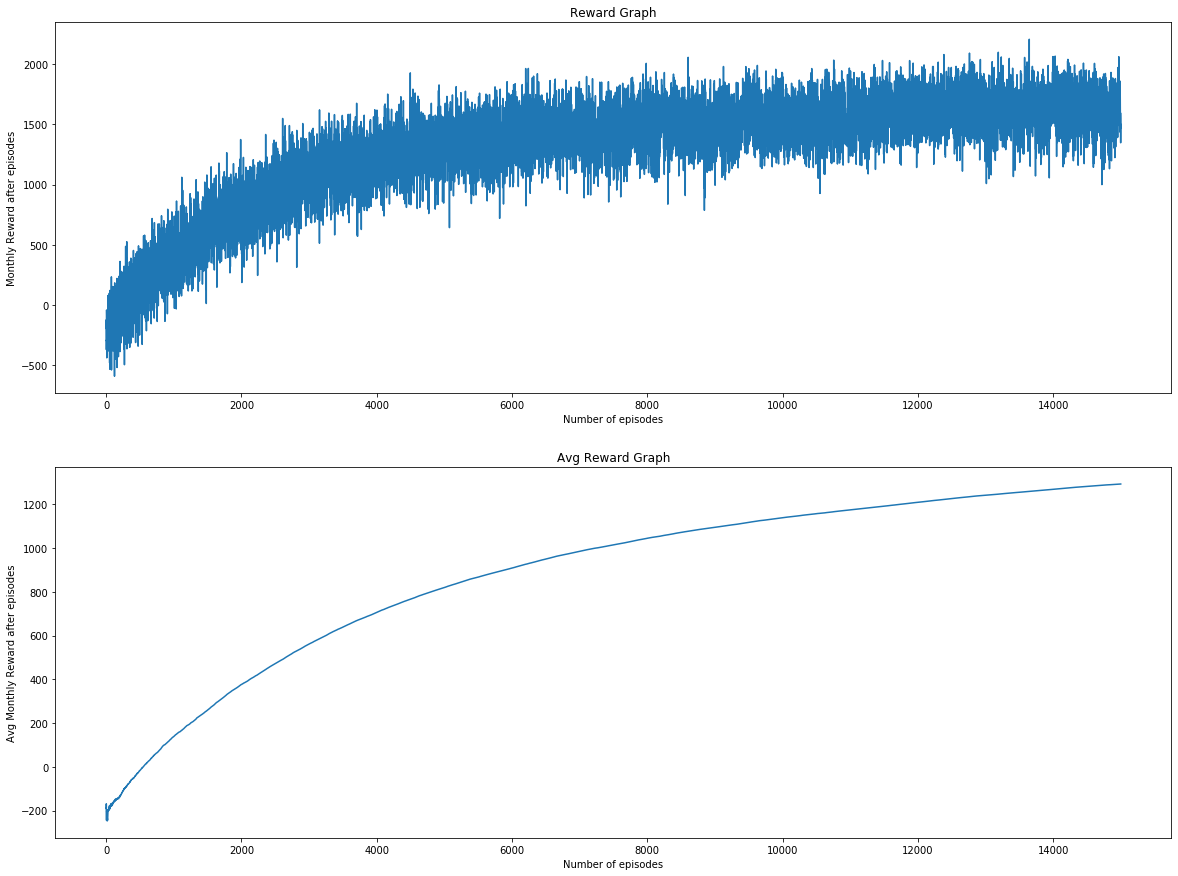

In [18]:
# Write the code to plot graphs for rewards tracked to show convergence

avg_monthly_rewards = [np.mean(rewards[0:x]) for x in range(Episodes)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

axes[0].plot(rewards)
axes[0].set_xlabel("Number of episodes")
axes[0].set_ylabel("Monthly Reward after episodes")
axes[0].set_title("Reward Graph")

axes[1].plot(avg_monthly_rewards)
axes[1].set_xlabel("Number of episodes")
axes[1].set_ylabel("Avg Monthly Reward after episodes")
axes[1].set_title("Avg Reward Graph")

plt.show()

#### Rewards tracked per episode showing convergence as per above plot (variation within small range). 

#### Avg monthly reward is also showing convergence. Not much variation.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

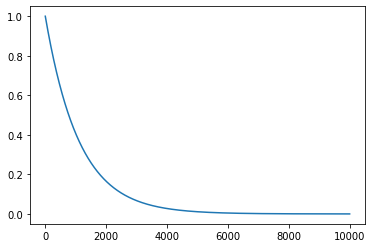

In [20]:
plt.plot(time, epsilon)
plt.show()

#### Epsilon-decay function used for the model

<div class="alert alert-block alert-info">
This is the epsilon-decay function used for the model.
</div>

In [21]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0005*i))

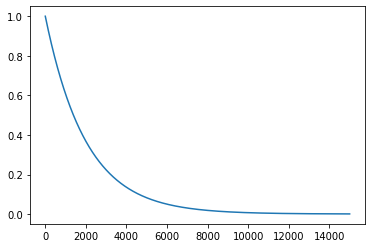

In [22]:
plt.plot(time, epsilon)
plt.show()